In [ ]:
import pydicom
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
dcmImage = pydicom.dcmread("trial.dcm")
dcm_scan = dcmImage.pixel_array
print(np.shape(dcm_scan))

In [8]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import os.path

In [30]:
matFile = loadmat(os.path.join('data', 'fractals_192.mat'))
matImage = matFile['X']
ImageTICI = matFile['TICI_report']

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        image = loadmat(os.path.join(folder, filename))
        images.append(image)
    return images

prelim_images = load_images_from_folder('data')

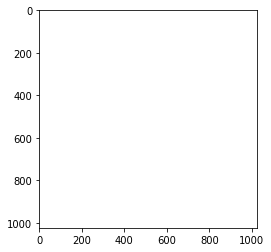

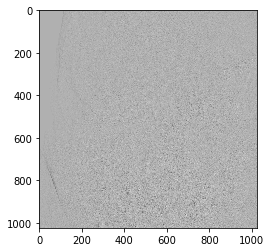

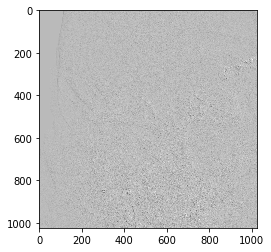

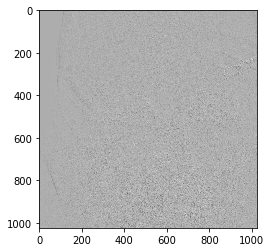

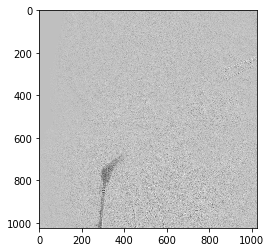

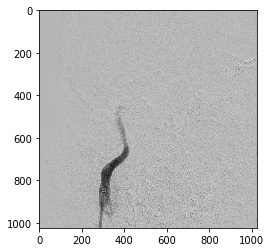

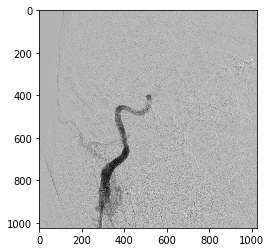

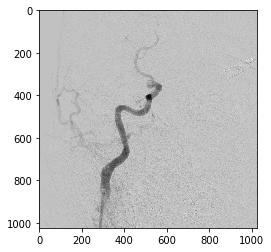

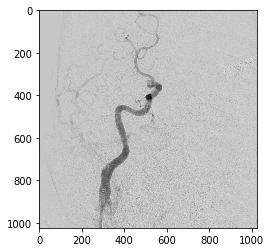

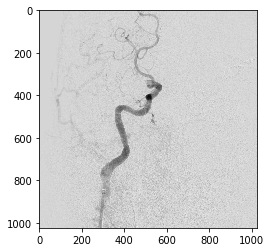

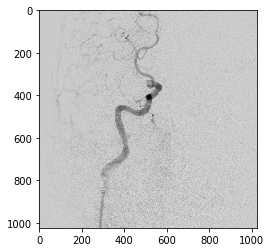

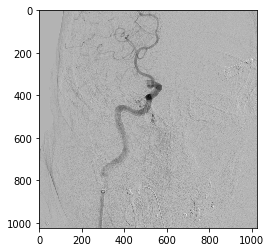

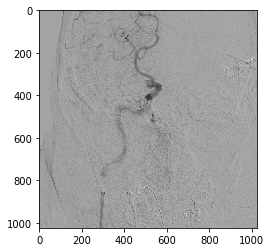

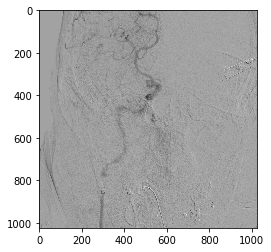

In [37]:
for i in range(len(matImage[0, 0])):
    plt.figure()
    plt.imshow(matImage[:,:,i], cmap = 'gray')

In [42]:
for im in prelim_images:
    print(im['X'].shape)
# find the most frames in an image and pad the others with zeros so that all have the same number of frames...

(1024, 1024, 14)
(1024, 1024, 23)
(1024, 1024, 19)
(1024, 1024, 16)
(1024, 1024, 17)
(1024, 1024, 17)
(1024, 1024, 22)


In [ ]:
# preprocess the data

In [ ]:
# use keras inception v3 to train on the time stamped image frames
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)
    # fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # logistic layer
    predictions = Dense(5, activation='softmax')(x) # 5 is the number of classes in the data, since TICI is 0,1,2a,2b,3

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def create_generators():
    train_d_gen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)
    
    train_d_gen.fit(x_train)
    
    train_gen = train_d_gen.flow(x_train, y_train)
    
    validation_gen = ImageDataGenerator().flow(x_test, y_test)
    
    return train_generator, validation_generator

def train_model(model, nb_epoch, generators, callbacks=[]):
    train_generator, validation_generator = generators
    model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        validation_data=validation_generator,
        validation_steps=10,
        epochs=nb_epoch,
        callbacks=callbacks)
    return model

In [ ]:
model = create_model()
generators = create_generators()

model = train_model(model, 10, generators)

In [ ]:
# general crossvalidation skeleton

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

tprs = []
aucs = []
i = 1

for train, test in cv.split(X, Y):
    model.fit(X[train], Y[train])
    Y_pred = model.predict(X[test])
    fpr, tprs, thresholds = roc_curve(Y[test], Y_pred)
    tpr.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw = 1, alpha = 0.3, label = 'ROC fold %d (AUC - %0.2f)' % (i, roc_auc))
    plt.legend()
    i+=1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Chance', alpha=.8)

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PLS-DA ROC Curve with Crossvalidation')
plt.legend(loc="lower right")
plt.savefig('ROC Curve for PLS-DA with Crossvalidation-14comp.jpg')